# Apply image filters

Enhance images with blur, sharpen, edge detection, and other filters.

**What's in this recipe:**
- Apply common image filters
- Test filters before applying
- Process multiple images in batch


## Problem

Images need enhancement or artistic effects:

- Reduce noise with blur
- Enhance details with sharpen
- Detect edges for analysis
- Apply artistic filters

Manually filtering each image is slow and inconsistent.


## Solution

**Without Pixeltable:** Write a loop to apply Pillow's `ImageFilter` (or OpenCV filters), manage file paths and results yourself.

**With Pixeltable:** Use Pillow's `ImageFilter` in Pixeltable UDFs. Use Pixeltable's Query-then-Commit pattern: test filters, then apply to all—the key to fast feedback loops.

For more on this pattern, see [Get fast feedback on transformations](./iter-fast-feedback-loops.ipynb).

### Setup


In [ ]:
%pip install -qU pixeltable

In [1]:
import pixeltable as pxt
from PIL import ImageFilter

In [2]:
# Create a fresh directory (drop existing if present)
pxt.drop_dir('image_demo', force=True)
pxt.create_dir('image_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata
Created directory 'image_demo'.


### Load images


In [3]:
t = pxt.create_table('image_demo.filters', {'image': pxt.Image})
t.insert([
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000001.jpg'},
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000016.jpg'},
])

Created table 'filters'.
Inserting rows into `filters`: 2 rows [00:00, 674.76 rows/s]
Inserted 2 rows with 0 errors.


2 rows inserted, 4 values computed.

### Define functions to apply filters

Defining UDFs makes our code easier to iterate on and easier to reuse in production when we commit to a transformation.

In [4]:
@pxt.udf
def apply_blur(img: pxt.Image) -> pxt.Image:
    """Apply blur filter."""
    return img.filter(ImageFilter.BLUR)

@pxt.udf
def apply_sharpen(img: pxt.Image) -> pxt.Image:
    """Apply sharpen filter."""
    return img.filter(ImageFilter.SHARPEN)

@pxt.udf
def apply_find_edges(img: pxt.Image) -> pxt.Image:
    """Apply edge detection filter."""
    return img.filter(ImageFilter.FIND_EDGES)

@pxt.udf
def apply_edge_enhance(img: pxt.Image) -> pxt.Image:
    """Apply edge enhancement filter."""
    return img.filter(ImageFilter.EDGE_ENHANCE)

### Test filters with a query

Use `.select()` with `.head()` to preview results. Using `.head()` is optional but recommended for expensive operations.

image,apply_blur,apply_sharpen
,,

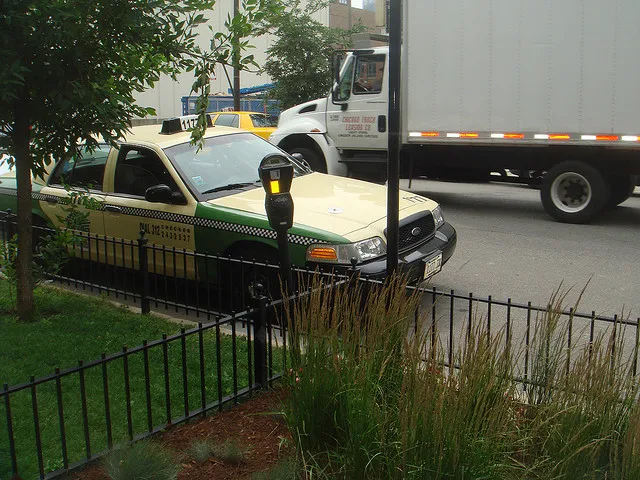
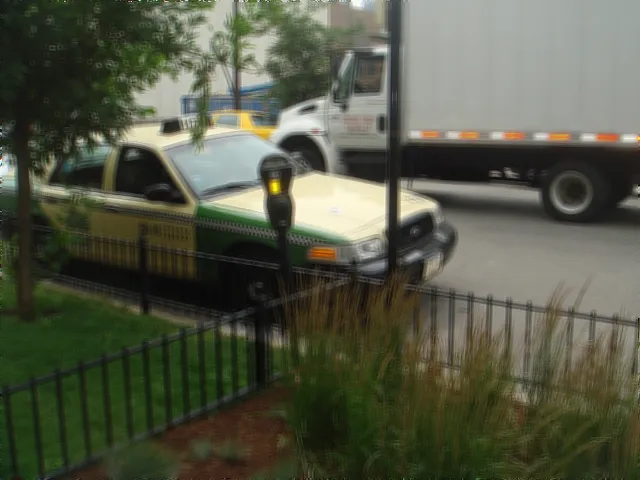
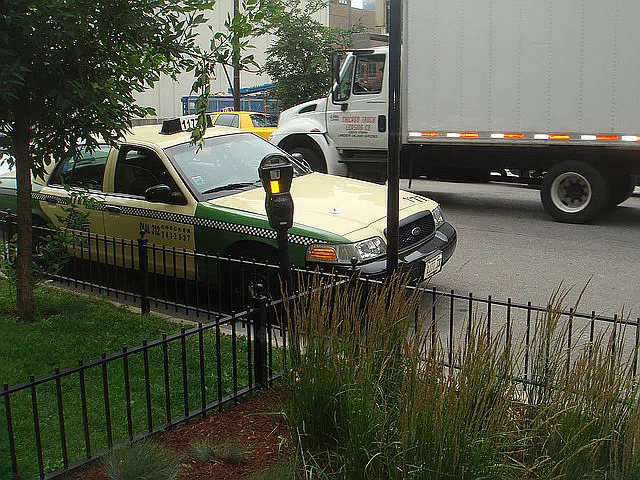

In [5]:
# Test blur and sharpen
t.select(
    t.image,
    apply_blur(t.image),
    apply_sharpen(t.image)
).head(1)

### Commit changes with a computed column

In [6]:
# Add filter columns
t.add_computed_column(blurred=apply_blur(t.image))
t.add_computed_column(sharpened=apply_sharpen(t.image))
t.add_computed_column(edges=apply_find_edges(t.image))
t.add_computed_column(edge_enhanced=apply_edge_enhance(t.image))

Added 2 column values with 0 errors.
Added 2 column values with 0 errors.
Added 2 column values with 0 errors.
Added 2 column values with 0 errors.


2 rows updated, 2 values computed.

### View results

Compare original and filtered images.


image,edges,edge_enhanced
,,
,,

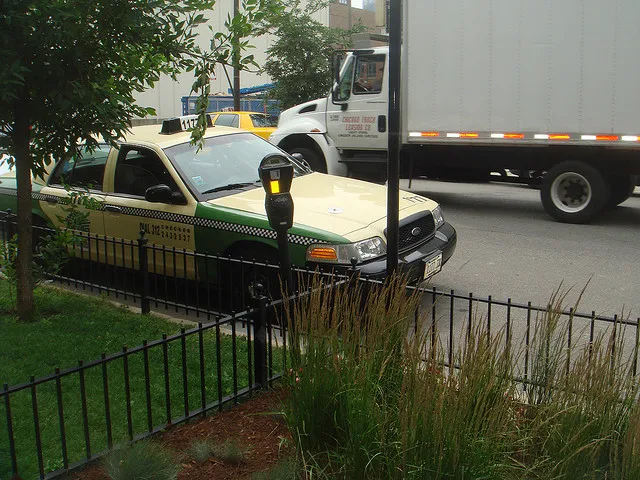
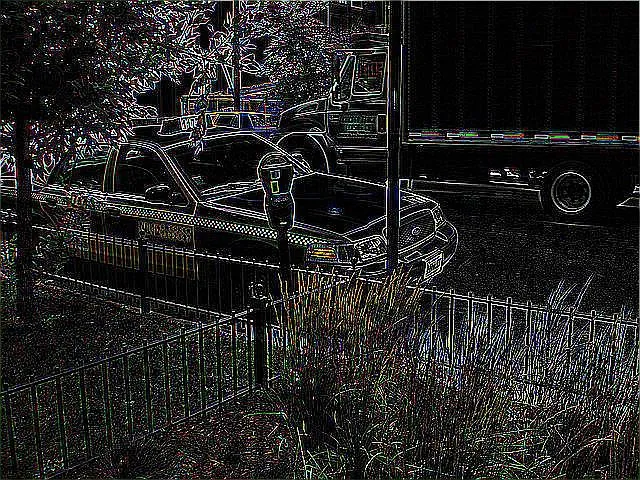
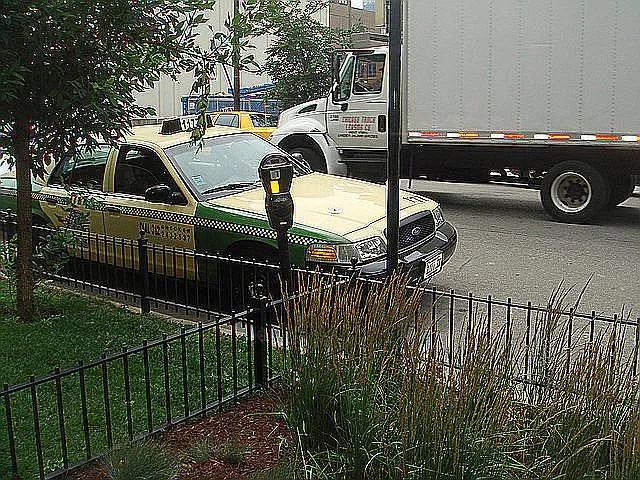
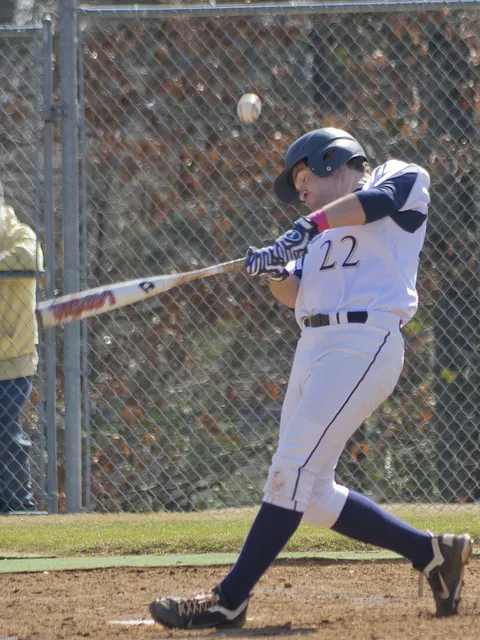
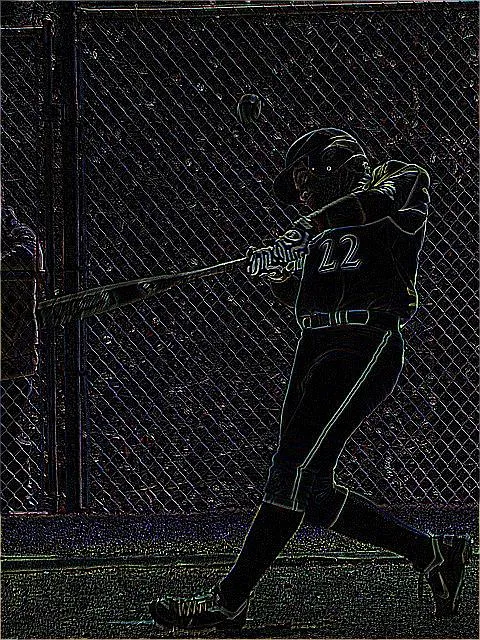
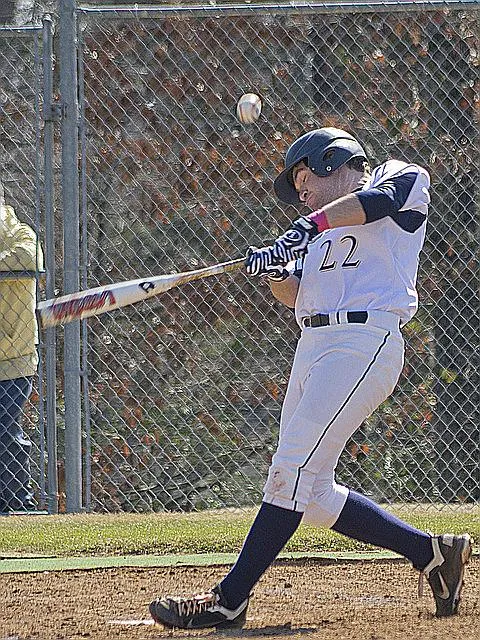

In [7]:
# Compare blur and sharpen
t.select(t.image, t.blurred, t.sharpened).show()

# Compare edge detection filters
t.select(t.image, t.edges, t.edge_enhanced).show()

## Explanation

**How it works:**
- Use PIL's `ImageFilter` module for common image processing filters
- Each filter modifies the image in a specific way

**Workflow:**
1. Define UDFs for each filter type
2. Test with `.select().head()` to preview filters
3. Add as computed columns to apply to all images

**Common filters:**
- `BLUR`: Reduce noise and detail
- `SHARPEN`: Enhance edges and detail
- `FIND_EDGES`: Detect edges for analysis
- `EDGE_ENHANCE`: Enhance edges while preserving image


## See also

- [Test transformations with fast feedback loops](./iter-fast-feedback-loops.ipynb)
- [Adjust image brightness and contrast](./img-brightness-contrast.ipynb)
- *Pillow techniques from [Real Python: Image Processing With the Python Pillow Library](https://realpython.com/image-processing-with-the-python-pillow-library/)*
